## **Redes Neurais Artificiais na Análise de Evasão nas Licenciaturas do IFNMG-Salinas**

---

---

Classificação de evasão escolar no ensino superior. O objetivo foi desenvolver um modelo utilizando redes neurais artificiais *Multilayer Perceptron* para classificar a situação do discente, permanência ou evasão, frente aos seus dados socioeconômicos, nos curos de licenciatura do IFNMG-Salinas.

##**Conjunto de dados**
A base de dados foi formada a partir da tabulação de arquivos físicos de questionários socioeconômicos em planilha eletrônica. A coleta foi realizada na secretaria de registros acadêmicos do IFNMG - Campus Salinas, mediante autorização da direção de ensino, desde que fosse preservado o anonimato dos discentes.

Foram coletadas 256 amostras de dados relativas às turmas de 2017 e 2018 doscursos de licenciatura em Ciências Biológicas, Física, Matemática e Química. Dessas 256 amostras, 135 eram de discentes evadidos e 121 de discentes regularmente matriculados(não evadidos). 

Cada amostra é caracterizada por 22 atributos discretos, nos quais:  
* 21  deles são os atributos de entrada (características)
* 1   atributo de saída (rótulo, situação do discente: evadiu ou  não evadiu).

**Importação de dados**


---


In [ ]:
#[1]Bibliotecas
from google.colab import files
import pandas as pd
import io

In [ ]:
#[2]importando conjuntos e dados já limpo(removidas variáveis descessárias e com dados faltantes)

uploaded = files.upload() # uploaded é um dicionário, sendo a chave o nome do arquivo
data_evasao = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

Saving data_licen.csv to data_licen.csv


In [ ]:
#visualizando dados
data_evasao.head(2)

,atv_remunerada,renda_mensal,num_mem_familia,renda_mensal_familia,sit_pai_trabalho,sit_mae_trabalho,ens_fundamental,ens_medio,tempo_concluiu_ens_medio,cor,hab_ler_jornal_revista,livros_lidos_ano,atv_ocup_tempo,meio_informado,faixa_etaria,procedencia,rep_ens_fundamental,rep_ens_medio,esc_pai,esc_mae,deficiencia,Evadiu
0,Nao,Nao tenho nenhuma renda mensal.,De 1 a 3 pessoas,"De 1 até 1,5 salário mínimo.",Outra situação,Outra situação,Escola pública municipal,Escola pública federal,Há mais de 5 anos,"Pardo(a), Mulato(a)",Diariamente,Mais de 05 livros,Nenhuma dessas atividades,Internet,De 30 a 39 anos,Zona rural,1 vez,Nenhuma vez,Ensino fundamental completo,Ensino fundamental incompleto,Não apresento nenhum tipo de deficiência,Sim
1,Nao,Nao tenho nenhuma renda mensal.,De 4 a 6 pessoas,"De 1 até 1,5 salário mínimo.",Trabalha regularmente,Trabalha regularmente,Escola pública estadual,Escola pública estadual,Entre 3 e 4 anos (incompletos),"Pardo(a), Mulato(a)",Semanalmente,Mais de 05 livros,Televisão,Jornal falado (TV),De 20 a 24 anos,Zona urbana,Nenhuma vez,Nenhuma vez,Ensino fundamental incompleto,Ensino fundamental incompleto,Não apresento nenhum tipo de deficiência,Sim


##**Pré-Processamento**

**Transformação/Conversão de dados**


---
A *Multilayer Perceptron* não consegue processar diretamente dados categóricos,dessa forma, no pré-processamento os dados foram convertidos para numéricos. Para isso, utilizou-se a codificação 1-de-n, na qual é criado um atributo para cada valor categórico. O atributo que corresponde ao valor é preenchido com 1 e os demais com 0.

O processo foi realizado com o auxilio do  ```OneHotEncoder``` .


In [ ]:
#Bibliotecas
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

enc.fit(data_evasao)  #Ajuste do OneHotEncoder para pré-processamento

new_data = enc.transform(data_evasao).toarray() #Transformação dos dados categóricos em características binárias

print('Conjunto de dados transformado com sucesso!\n')
print(f'Número de colunas do conjunto de dados: {new_data.shape[1]}')
print(f'Número de linhas do conjunto de dados: {new_data.shape[0]}')

Conjunto de dados transformado com sucesso!

Número de colunas do conjunto de dados: 119
Número de linhas do conjunto de dados: 256


**Separação das variáveis de entrada e saída**


---


In [ ]:
#Separação das entradas e saídas do modelo
X = new_data[:, :(new_data.shape[1]-2)]   
y = new_data[:, new_data.shape[1]-2:] #Duas últimas colunas do array

print(f'Entradas: {X.shape[1]}')
print(f'Saídas: {y.shape[1]}')

Entradas: 117
Saídas: 2


In [ ]:
#Bibliotecas
import numpy as np

# Indentificando os rótulos das classes
data = np.array(data_evasao)
labels = []
for line in range(data.shape[0]):
  if(labels.count(data[line, data.shape[1]-1])==0):
    labels.append(data[line, data.shape[1]-1])

## **Seleção de Topologias por Validação K-Fold**

In [ ]:
#Bibliotecas
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore") # ignorando warnings da MLP

#Gerando os conjuntos de treinamento e teste
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.25)

# ponto de partida da camada oculta
neurons = (train_x.shape[1]+train_y.shape[1])//2
rand_seeds =  [0, 32, 64, 96, 127]
actv_funcs =  ['logistic', 'relu']
max_its = [250, 500, 750, 1000]

hp = [] 
val_scores = []
train_scores = []
mean_scores =[]

#Preparação do procedimento de validação cruzada
cv = KFold(n_splits=10, random_state=1, shuffle=True)

print('AC.VAL. + Desvio padrão      |       TOPOLOGIA ')

# loop de otimização
while(neurons>=1):
  for actv_func in actv_funcs:
    vc = []
    for r_seed in rand_seeds:
      # define modelo com base no hiperparametro
      model = MLPClassifier(neurons,activation=actv_func, max_iter=1000, alpha=0.01,  random_state=r_seed,
                      solver='sgd', learning_rate_init=0.1, momentum=0.9, learning_rate='adaptive', verbose=0 )
      
      # Validação k-fold
      vs = cross_val_score(model, train_x, train_y, cv=cv)
      
      vc.extend(vs)
      
      val_acc = np.mean(vs) #média dos valores kfold
      val_sd = np.std(vs)
      val_scores.append(val_acc)
    
      hp.append([neurons, actv_func, r_seed])

      print('%.3f  -  %.3f           ' % (val_acc*100, val_sd*100), [neurons, actv_func, r_seed])
   # print('%.3f-%.3f      ' % (np.mean(vc),np.std(vc)),'      ', [neurons, actv_func])
  neurons = neurons//2


print('\n\n------------------ RESULTADO -------------------------------')

best_i = np.argmax(val_scores)                                                                                                                                                                                                                                                                                                                          
print('\nMelhor modelo: ', best_i, hp[best_i])
print('Acurácia do Conjunto de Validação: {:.4}%'.format(val_scores[best_i]*100))




AC.VAL. + Desvio padrão      |       TOPOLOGIA 
58.316  -  7.073            [59, 'logistic', 0]
58.289  -  5.984            [59, 'logistic', 32]
58.342  -  6.529            [59, 'logistic', 64]
57.763  -  8.803            [59, 'logistic', 96]
60.421  -  9.118            [59, 'logistic', 127]
56.211  -  8.339            [59, 'relu', 0]
58.316  -  5.827            [59, 'relu', 32]
55.211  -  8.487            [59, 'relu', 64]
55.184  -  6.824            [59, 'relu', 96]
56.789  -  8.674            [59, 'relu', 127]
58.868  -  5.295            [29, 'logistic', 0]
56.763  -  8.807            [29, 'logistic', 32]
55.711  -  5.454            [29, 'logistic', 64]
57.816  -  8.561            [29, 'logistic', 96]
55.711  -  6.390            [29, 'logistic', 127]
56.237  -  4.234            [29, 'relu', 0]
55.684  -  8.414            [29, 'relu', 32]
57.789  -  8.037            [29, 'relu', 64]
57.816  -  8.561            [29, 'relu', 96]
55.132  -  9.150            [29, 'relu', 127]
57.316  -  5

## **Treinamento**

Perda Logarítmica: 0.06511


Text(0, 0.5, 'perda')

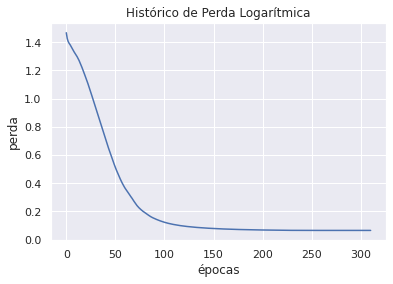

In [ ]:
# treina com hiperparametro mais adequado
model = MLPClassifier(hp[best_i][0],activation=hp[best_i][1], max_iter=5000, alpha=0.1,
                      solver='sgd', learning_rate_init=0.1, momentum=0.9, learning_rate='adaptive', verbose=0 )
      
model = model.fit(train_x, train_y)

train_y_pred = model.predict(train_x)

#Calcula a perda logaritmica
l_loss = model.best_loss_

print('Perda Logarítmica: {:.4}'.format(l_loss))

# exibindo a curva de perda logarítmica
plt.plot(model.loss_curve_)
plt.title('Histórico de Perda Logarítmica')
plt.xlabel('épocas')
plt.ylabel('perda')

## **Análise dos conjuntos de treinamento e teste**

--------------- ANÁLISE DO CONJUNTO DE TREINAMENTO -------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00       103

   micro avg       1.00      1.00      1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192
 samples avg       1.00      1.00      1.00       192

Acurácia no Conjunto de Treinamento: 100.0%



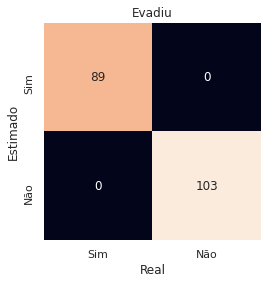

In [ ]:
print('--------------- ANÁLISE DO CONJUNTO DE TREINAMENTO -------------------\n')

# Análise do conjunto de treinamento
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


#print(' Relatório de Classificação')
print(classification_report(train_y, train_y_pred)) # mostra relatório

acc_train = accuracy_score(train_y, train_y_pred)
print('Acurácia no Conjunto de Treinamento: {:.4}%\n'.format(acc_train*100))

mat = confusion_matrix(train_y.argmax(axis=-1), train_y_pred.argmax(axis=-1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Evadiu')
plt.xlabel('Real')
plt.ylabel('Estimado');

----------------- ANÁLISE DO CONJUNTO DE TESTE -----------------------

              precision    recall  f1-score   support

           0       0.72      0.56      0.63        32
           1       0.64      0.78      0.70        32

   micro avg       0.67      0.67      0.67        64
   macro avg       0.68      0.67      0.67        64
weighted avg       0.68      0.67      0.67        64
 samples avg       0.67      0.67      0.67        64

Acurácia de Teste: 67.19%



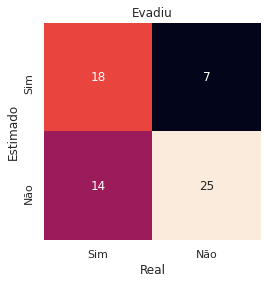

In [ ]:
print('----------------- ANÁLISE DO CONJUNTO DE TESTE -----------------------\n')
#Análise do conjunto de teste
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

test_y_pred = model.predict(test_x)

print(classification_report(test_y, test_y_pred))

acc_test = accuracy_score(test_y, test_y_pred)
test_std = np.std(acc_test)
print('Acurácia de Teste: {:.4}%\n'.format(acc_test*100))

# matriz de confusão
mat = confusion_matrix(test_y.argmax(axis=1), test_y_pred.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Evadiu')
plt.xlabel('Real')
plt.ylabel('Estimado');

